<a href="https://colab.research.google.com/github/crazat/crazat.githurb.io/blob/main/k_NN_%EB%B0%8F_tree_%EB%AA%A8%EB%8D%B8_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 데이터 경로 변수

In [ ]:
DATA_PATH = "/content/drive/MyDrive/머신러닝/data/"
DATA_PATH

'/content/drive/MyDrive/머신러닝/data/'

- 타이타닉 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv(f"{DATA_PATH}titanic_train.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}titanic_test.csv") # 테스트 데이터
test_target = pd.read_csv(f"{DATA_PATH}titanic_test_target.csv") # 테스트데이터 정답값
train.shape , test.shape , test_target.shape

((916, 12), (393, 11), (393, 2))

- 결측치 확인하기

In [ ]:
train.isnull().sum()

,0
passengerid,0
survived,0
pclass,0
name,0
gender,0
age,180
sibsp,0
parch,0
ticket,0
fare,0


In [ ]:
test.isnull().sum()

,0
passengerid,0
pclass,0
name,0
gender,0
age,83
sibsp,0
parch,0
ticket,0
fare,1
cabin,308


- 학습 데이터에서 얻은 통계량을 이용하여 결측치를 채워야한다.

In [ ]:
age_mean = train["age"].mean() # 평균
fare_median = train["fare"].median() # 중앙값
cabin_unk = "UNK" # 새로운 범주
embarked_mode = train["embarked"].mode()[0] # 최빈값
age_mean , fare_median ,cabin_unk , embarked_mode

(29.904891304347824, 14.5, 'UNK', 'S')

- 학습데이터 결측치 처리

In [ ]:
train["age"] = train["age"].fillna(age_mean)
train["cabin"] = train["cabin"].fillna(cabin_unk)

- 테스트데이터 결측치 처리

In [ ]:
test["age"] = test["age"].fillna(age_mean)
test["fare"] = test["fare"].fillna(fare_median)
test["cabin"] = test["cabin"].fillna(cabin_unk)
test["embarked"] = test["embarked"].fillna(embarked_mode)

In [ ]:
train.isnull().sum().sum() , test.isnull().sum().sum()

(0, 0)

- 특성으로 사용할 변수 추가하기

In [ ]:
cols = ["age","sibsp","parch","fare","pclass","gender","embarked"]
train_ft = train[cols].copy()
test_ft = test[cols].copy() # 테스트 데이터
train_ft.shape, test_ft.shape

((916, 7), (393, 7))

- 범주형 변수 원핫인코딩하여 특성으로 추가하기

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cols = ['gender','embarked']
enc = OneHotEncoder(handle_unknown = 'ignore') # 모르는 범주가 있을 경우 무시
enc.fit(train_ft[cols])

OneHotEncoder(handle_unknown='ignore')

In [ ]:
# 학습 데이터
tmp = pd.DataFrame(
    enc.transform(train_ft[cols]).toarray(), # ndarray
    columns = enc.get_feature_names_out() # 컬럼명
)
train_ft = pd.concat([train_ft,tmp],axis=1)
train_ft.head()

,age,sibsp,parch,fare,pclass,gender,embarked,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,71.0,0,0,49.5042,1,male,C,0.0,1.0,1.0,0.0,0.0
1,34.0,0,0,8.0500,3,male,S,0.0,1.0,0.0,0.0,1.0
2,29.0,3,1,22.0250,3,male,S,0.0,1.0,0.0,0.0,1.0
3,18.0,1,1,13.0000,2,female,S,1.0,0.0,0.0,0.0,1.0
4,48.0,0,0,26.5500,1,male,S,0.0,1.0,0.0,0.0,1.0


In [ ]:
# 테스트 데이터
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
test_ft = pd.concat([test_ft,tmp],axis=1)
test_ft.head()

,age,sibsp,parch,fare,pclass,gender,embarked,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,62.000000,0,0,26.5500,1,male,S,0.0,1.0,0.0,0.0,1.0
1,28.000000,0,0,47.1000,1,male,S,0.0,1.0,0.0,0.0,1.0
2,24.000000,0,0,9.5000,3,male,S,0.0,1.0,0.0,0.0,1.0
3,29.904891,0,0,7.7333,3,female,Q,1.0,0.0,0.0,1.0,0.0
4,18.500000,0,0,7.2833,3,female,Q,1.0,0.0,0.0,1.0,0.0


- 문자열 데이터 제거

In [ ]:
cols = ["gender","embarked"]
train_ft = train_ft.drop(columns=cols)
test_ft = test_ft.drop(columns=cols)

- Min-Max Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_ft)

MinMaxScaler()

In [ ]:
train_ft[train_ft.columns] = scaler.transform(train_ft) # 학습 데이터
train_ft.head()

,age,sibsp,parch,fare,pclass,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,0.887260,0.000,0.000000,0.096626,0.0,0.0,1.0,1.0,0.0,0.0
1,0.423776,0.000,0.000000,0.015713,1.0,0.0,1.0,0.0,0.0,1.0
2,0.361142,0.375,0.111111,0.042990,1.0,0.0,1.0,0.0,0.0,1.0
3,0.223350,0.125,0.111111,0.025374,0.5,1.0,0.0,0.0,0.0,1.0
4,0.599148,0.000,0.000000,0.051822,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
test_ft[test_ft.columns] = scaler.transform(test_ft) # 테스트 데이터
test_ft.head()

,age,sibsp,parch,fare,pclass,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,0.774521,0.0,0.0,0.051822,0.0,0.0,1.0,0.0,0.0,1.0
1,0.348616,0.0,0.0,0.091933,0.0,0.0,1.0,0.0,0.0,1.0
2,0.298509,0.0,0.0,0.018543,1.0,0.0,1.0,0.0,0.0,1.0
3,0.372478,0.0,0.0,0.015094,1.0,1.0,0.0,0.0,1.0,0.0
4,0.229613,0.0,0.0,0.014216,1.0,1.0,0.0,0.0,1.0,0.0


- 정답 데이터

In [ ]:
target = train["survived"]
target

,survived
0,0
1,0
2,0
3,1
4,1
...,...
911,1
912,0
913,0
914,0


# k-NN(K-Nearest Neighber)
- k-최근접 이웃 알고리즘
- 새로운 샘플을 예측할 때 학습데이터의 K개의 가까운 이웃을 이용해서 예측
- 제일 가까운 데이터 포인트를 찾아서 결정하는 방식
- 회귀, 분류 둘다 사용 가능한 알고리즘

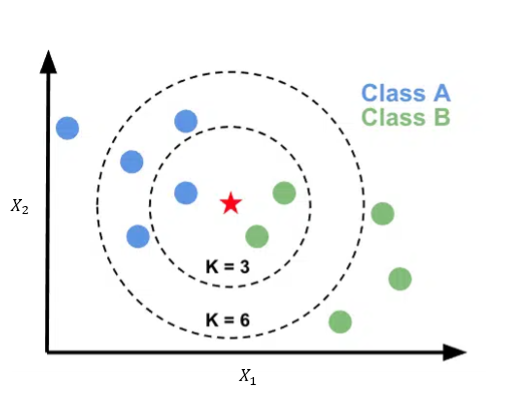

- 주요 파라미터
    - `n_neighbors` : 이웃수(default=5)
    - `weights`
        - 'uniform' : 기본값으로 거리에 상관없이 모든 이웃에 대하여 동일 취급
        - 'distance' : 가중치를 부여하여 멀리있는 이웃보다 가까운 이웃이 더 큰영향을 미치게 함
    - `p`
        - 2 : 기본값으로 유클리디안 거리
        - 1 : 맨해튼 거리

In [ ]:
# cv 객체 생성
from sklearn.model_selection import KFold
cv = KFold(n_splits=5,shuffle=True, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10,p=2,weights = "uniform")
scores = cross_val_score(model,train_ft,target,cv = cv ,scoring='roc_auc',n_jobs = -1)
print(scores) # 폴드별 검증점수 리스트
np.mean(scores) # cv 평균 점수

[0.90545113 0.94830151 0.89095326 0.86239547 0.90382565]


0.9021854035612025

- k 값이 너무 작을 경우 예측 성능 저하

In [ ]:
model = KNeighborsClassifier(n_neighbors=1,p=2,weights = "uniform")
scores = cross_val_score(model,train_ft,target,cv = cv ,scoring='roc_auc',n_jobs = -1)
print(scores) # 폴드별 검증점수 리스트
np.mean(scores) # cv 평균 점수

[0.81942356 0.83418051 0.78676471 0.71661338 0.78065849]


0.7875281291754318

- k 값이 너무 클 경우 예측 성능 저하

In [ ]:
model = KNeighborsClassifier(n_neighbors=300,p=2,weights = "uniform")
scores = cross_val_score(model,train_ft,target,cv = cv ,scoring='roc_auc',n_jobs = -1)
print(scores) # 폴드별 검증점수 리스트
np.mean(scores) # cv 평균 점수

[0.85288221 0.93131664 0.84000788 0.828394   0.86030392]


0.8625809278749756

- 테스트 데이터에 대하여 모델 평가

In [ ]:
from sklearn.metrics import roc_auc_score

model = KNeighborsClassifier(n_neighbors=10,p=2,weights = "uniform")
model.fit(train_ft,target) #학습 데이터 전체 다시학습

# 테스트 데이터 예측 및 평가
y_test = test_target["survived"] # 테스트셋 y값
pred = model.predict_proba(test_ft)[:,1] # 예측
roc_auc_score(y_test,pred) # AUC 평가

0.8773028130170988

# 의사결정나무(Decision Tree)
- 회귀, 분류 둘다 사용 가능한 알고리즘
- 여러 가지 규칙을 순차적으로 적용하면서 트리기반의 규칙을 만들어 예측하는 알고리즘
- 쉽게 규칙들을 if else 기반으로 찾아서 예측하는 알고리즘
- if else 기반의 규칙을 순수도를 이용하여 정한다.
- 데이터를 분할 할때 순수도가 높아지는 방향으로 규칙을 정한다.
- 순수도
    - 각 노드의 규칙에 의해 동일한 class가 포함되는 정도를 의미
    - 부모노드의 순수도에 비해 자식노드들의 순수도가 증가하도록 노드를 형성
- 순수도 척도
    - Gini와 Entropy : 둘다 0에 가까울수록 순수도가 높아 진다.
- Root node: 최상단에 위치
- Decision node: 중간에 위치하는 노드(Internal node)
- Leaf node: 최종 분류 값을 가짐



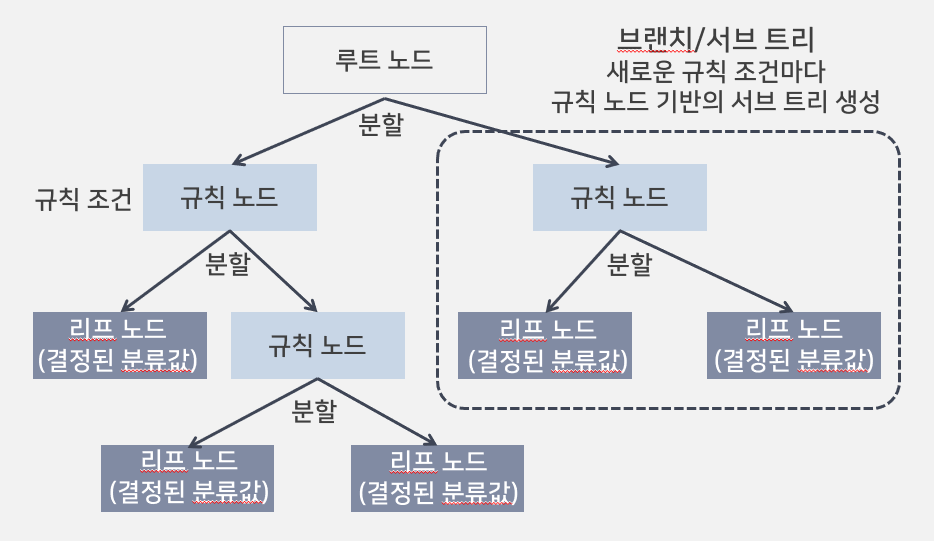

- 특성에 대한 규칙을 정하는 방법​
    - 특성의 값을 정렬후에 가능한 모든 분할 지점에 대한 순수도를 평가해서 최고의 분할 지점을 선택​

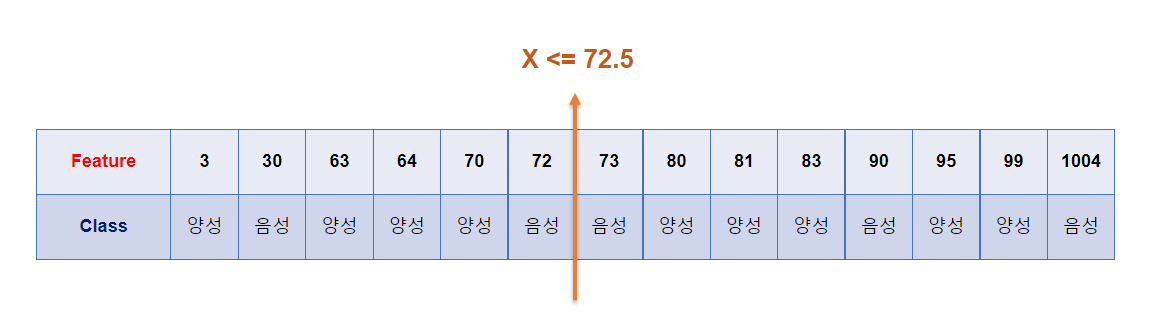

- 주요 파라미터
    - `random_state`: 시드값
    - `criterion`: 순수도 척도, default="gini"
        - "gini", "entropy"
    - `min_samples_split`
        - 노드를 분할하는데 필요한 최소 샘플수를 의미
        - 2가 기본값이며 2개 미만일경우 분할을 안한다.
        - 작게 설정할수록 많은 분할 노드가 생성되어 오버피팅가능성 증가
    - `max_depth`
        - 트리의 가능한 최대 깊이를 의미
        - None이 기본값
        - `max_depth` 깊이까지 완벽하게 클래스가 결정될때까지 깊이를 계속 키우거나 노드가 가지는 샘플수가 `min_samples_split` 보다 작아질 때까지 깊이를 증가시킴
    - `min_samples_leaf`
        - 기본값은 1이고 리프노드에 있어야하는 최소 샘플수를 의미
    - `max_features`
        - 기본값은 None
        - 최적의 분할을 위해 고려할 최대 피쳐 개수
        - int(개수) , float(비율) 또는 다음과 같이 인수로 줄 수 있다.
            - None: 전체 피쳐를 사용
            - "sqrt": sqrt(전체피쳐개수) 개수의 피쳐를 사용
            - "log2": log2(전체피쳐개수) 개수의 피쳐를 사용
    - `max_leaf_nodes`
        - 기본값은 None 으로 리프노드의 최대 개수를 의미

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=3,random_state=42)
scores = cross_val_score(model,train_ft,target,cv = cv ,scoring='roc_auc',n_jobs = -1)
print(scores) # 폴드별 검증점수 리스트
np.mean(scores) # cv 평균 점수

[0.90156642 0.94253657 0.89338235 0.87401623 0.89789389]


0.9018790938764694

In [ ]:
# 딕셔너리를 언패킹하여 키워드 아규먼트 전달 방식으로 하이퍼파라미터 지정
hp = {
    "random_state" : 42,
    "criterion" :"entropy",
    "min_samples_split": 5 ,
    "max_depth" : 5,
    "min_samples_leaf" : 20,
    "max_leaf_nodes" : None , # 제한 없음
}

model = DecisionTreeClassifier(**hp)
scores = cross_val_score(model,train_ft,target,cv = cv ,scoring='roc_auc',n_jobs = -1)
print(scores) # 폴드별 검증점수 리스트
np.mean(scores) # cv 평균 점수

[0.91610276 0.93894123 0.87591912 0.86614609 0.91882165]


0.9031861692871214

- 테스트 데이터에 대하여 모델 평가

In [ ]:
model.fit(train_ft,target) #학습 데이터 전체 다시학습

# 테스트 데이터 예측 및 평가
y_test = test_target["survived"] # 테스트셋 y값
pred = model.predict_proba(test_ft)[:,1] # 예측
roc_auc_score(y_test,pred) # AUC 평가

0.8713320463320465

- knn 모델과 tree 모델 예측 결과를 결합하여 성능 평가 해보기
    - 앙상블이라고 함

In [ ]:
# tree 모델 학습 및 test 데이터 예측
tree = DecisionTreeClassifier(**hp)
tree.fit(train_ft,target) #학습 데이터 전체 다시학습

pred_tree = tree.predict_proba(test_ft)[:,1] # 예측
pred_tree.shape

(393,)

In [ ]:
# knn 모델 학습 및 test 데이터 예측
knn = KNeighborsClassifier(n_neighbors=10,p=2,weights = "uniform")
knn.fit(train_ft,target) #학습 데이터 전체 다시학습

pred_knn = knn.predict_proba(test_ft)[:,1] # 예측
pred_knn.shape

(393,)

In [ ]:
pred = np.mean([pred_tree,pred_knn],axis=0) # 산술 평균 앙상블
pred.shape

(393,)

In [ ]:
# 테스트 데이터 예측 및 평가
y_test = test_target["survived"] # 테스트셋 y값
roc_auc_score(y_test,pred) # AUC 평가

0.8832046332046333

## 의사결정나무 시각화 하기

### 특성 중요도 시각화

- 시각화 라이브러리 및 모델 학습

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

model = DecisionTreeClassifier(max_depth=3,random_state=42)
model.fit(train_ft,target)

DecisionTreeClassifier(max_depth=3, random_state=42)

- 모델에 학습에 사용된 각 피쳐의 중요도를 확인할수 있다.

In [ ]:
train_ft.columns

Index(['age', 'sibsp', 'parch', 'fare', 'pclass', 'gender_female',
       'gender_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [ ]:
model.feature_importances_ # 컬럼명 순서!

array([0.02829865, 0.01582167, 0.        , 0.05374007, 0.07165837,
       0.83048123, 0.        , 0.        , 0.        , 0.        ])

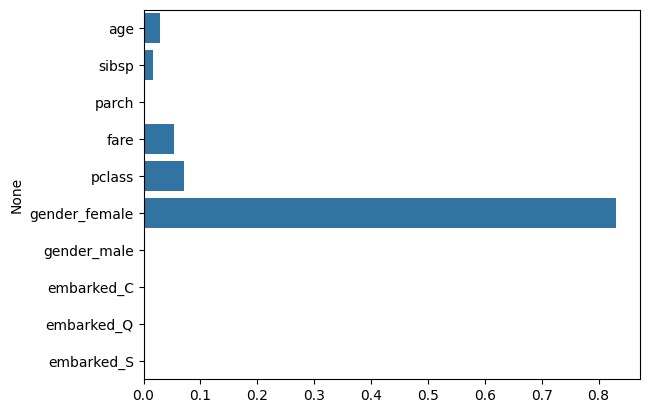

In [ ]:
sns.barplot(x=model.feature_importances_, y=train_ft.columns) # x 에 중요도, y 에 컬럼명 넣어서 시각화
plt.show()

### 의사결정나무 모델 시각화

In [ ]:
from sklearn.tree import export_graphviz # 그래프 형태로 시각화 할수 있는 파일을 저장하는 함수

params = {
    "decision_tree": model, # 학습된 모델 객체
    "out_file": "tree.dot", # 저장할 파일명
    "feature_names": train_ft.columns, # 사용한 피쳐들의 컬럼명
    "class_names": ["죽는다","산다"], # 클래스 별칭 리스트로 전달
}

export_graphviz(**params)

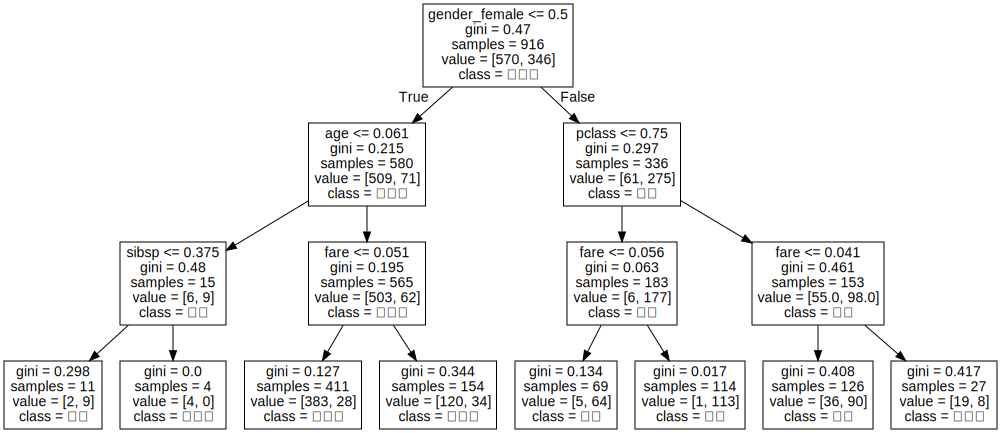

In [ ]:
import graphviz # 그래프 형태의 파일 형식을 읽어드려 시각화해주는 라이브러리
with open("tree.dot") as f:
    tree = graphviz.Source(f.read()) # Source 클래스에 파일객체를 넣어주면 그래프 객체가 반환된다.
tree